In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_excel("Данные.xlsx")

In [3]:
data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')


In [4]:
data

,Date,Value
0,1959-01-01,22.8331
1,1959-02-01,23.2802
2,1959-03-01,23.6156
3,1959-04-01,24.1186
4,1959-05-01,24.4820
...,...,...
355,1988-08-01,63.8851
356,1988-09-01,63.7040
357,1988-10-01,64.0220
358,1988-11-01,64.1173


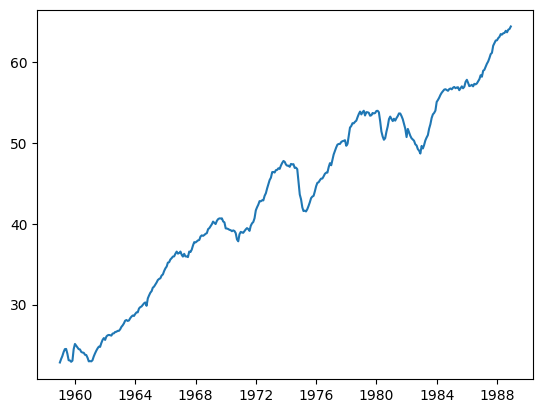

In [5]:
plt.plot(data['Date'], data['Value'])

# Тест Дики Фуллера

In [6]:
from statsmodels.tsa.stattools import adfuller


In [7]:
series = data['Value']
size = 12  # размер окна, так как разбиение по месяцам

In [8]:
def test(series, name):
    mean = pd.Series.rolling(series, window=size).mean()
    std = pd.Series.rolling(series, window=size).std()
    plt.figure(figsize=(17, 8))
    plt.plot(data['Date'], series, color='red', label=name)
    plt.plot(data['Date'], mean, color='green', label="rolling mean")
    plt.plot(data['Date'], std, color='blue', label="rolling std")

    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
    ADF = adfuller(data['Value'])
    p_value = ADF[0]
    t_value = ADF[4]['5%']

    if (p_value > t_value):
        print("Ряд не стационарный")
    else:
        print("Ряд стационарный")  #%%


import numpy as np
import pandas as pd
import statsmodels as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


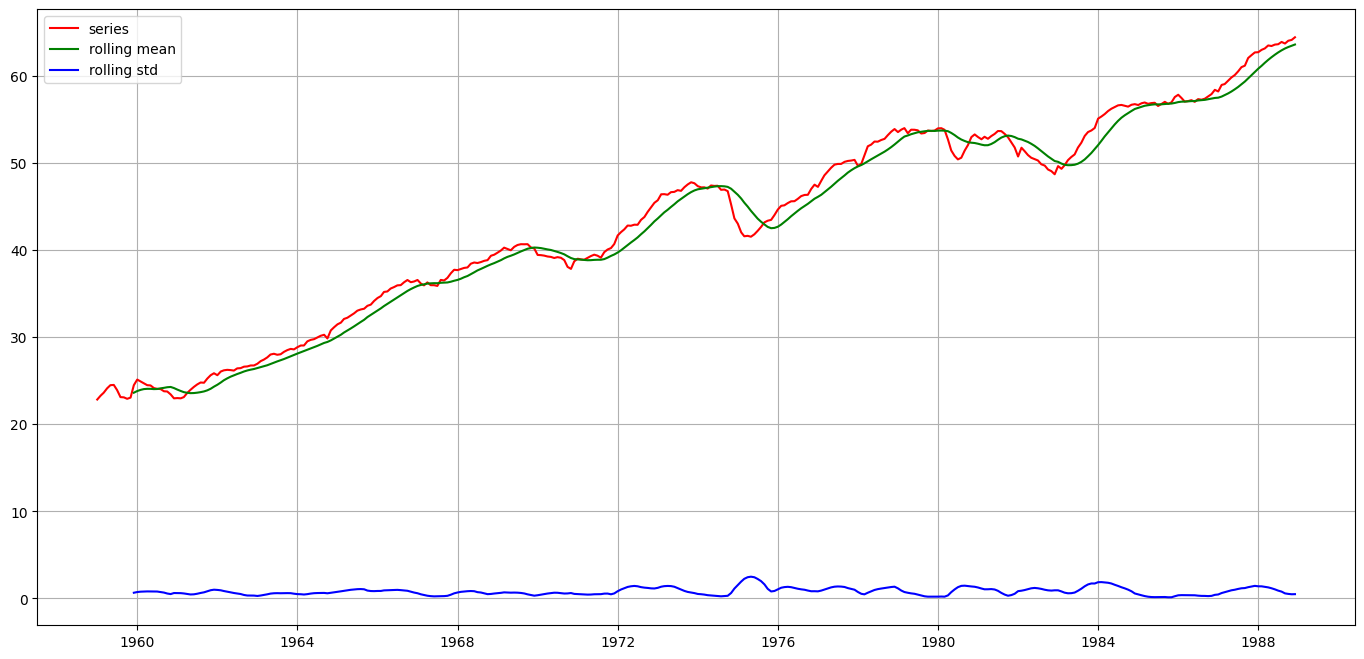

Ряд не стационарный


In [9]:
test(series, "series")

# Разбиение на тренд, сезональность остаток


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose


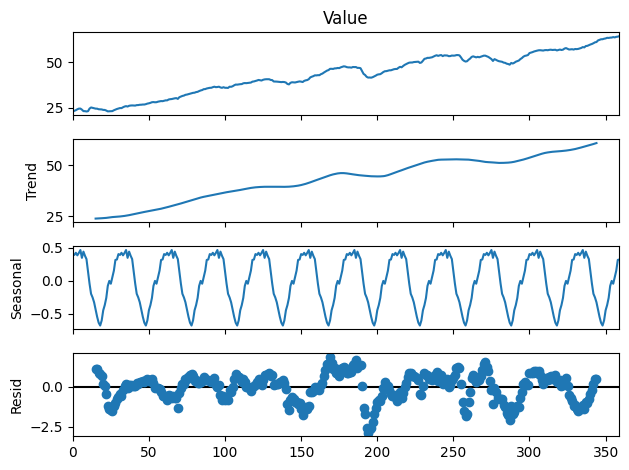

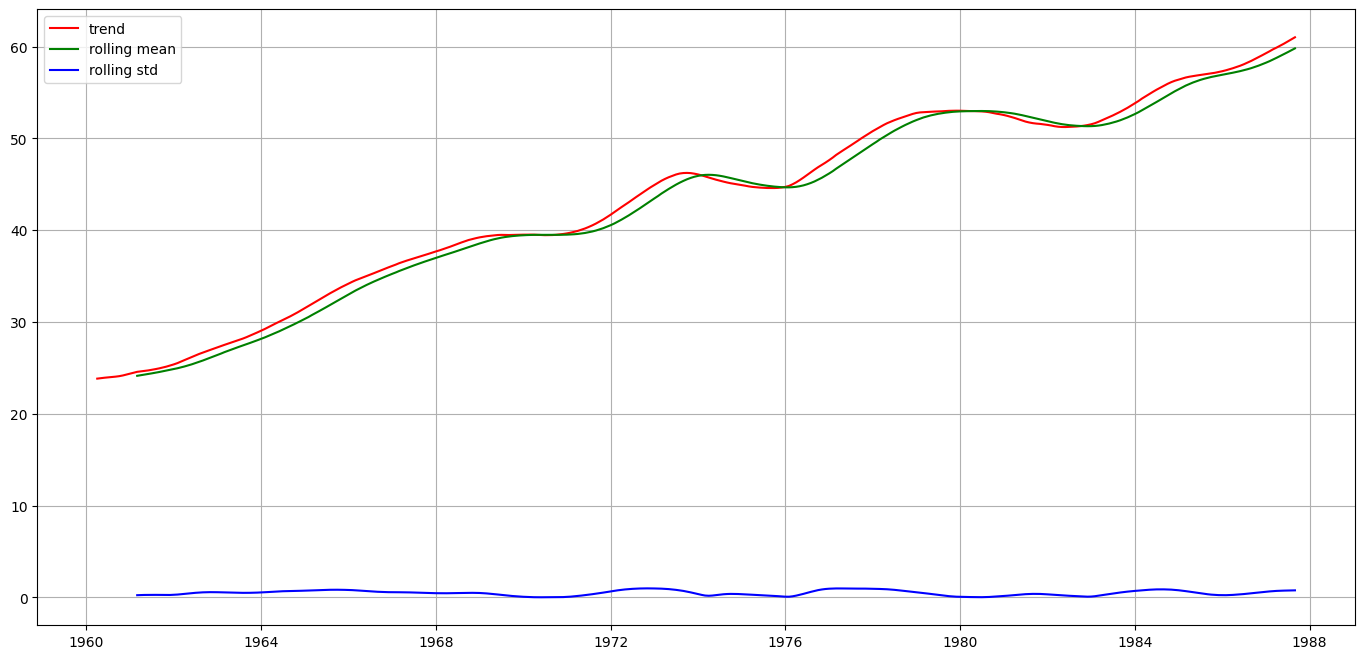

Ряд не стационарный


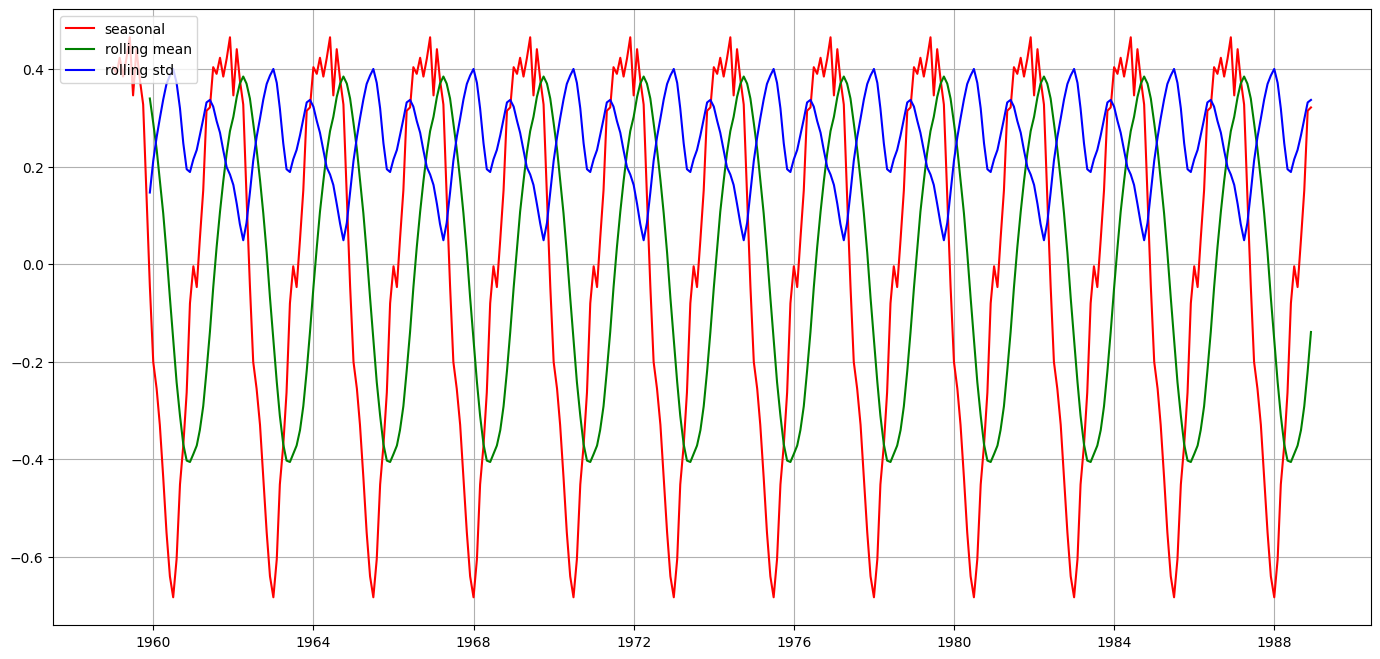

Ряд не стационарный


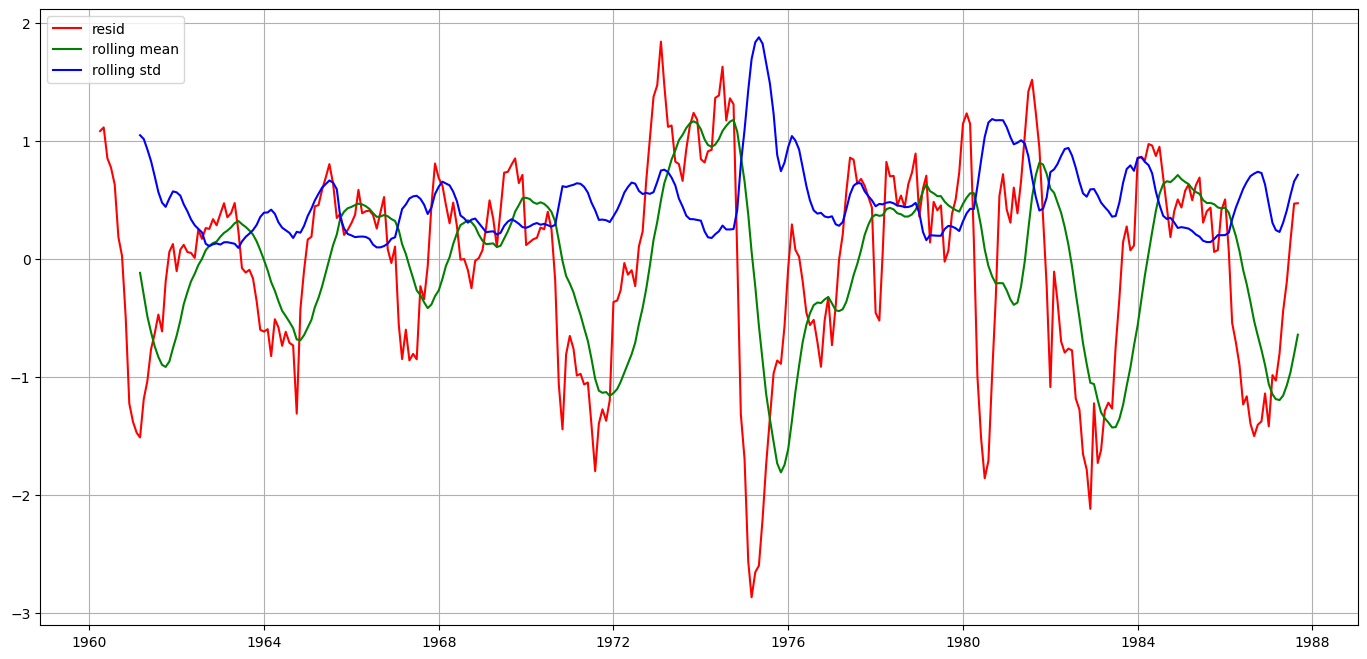

Ряд не стационарный


In [11]:
res = seasonal_decompose(data.Value, model='additive',period=30)
res.plot()
plt.show()

test(res.trend, "trend")
test(res.seasonal, "seasonal")
test(res.resid, "resid")



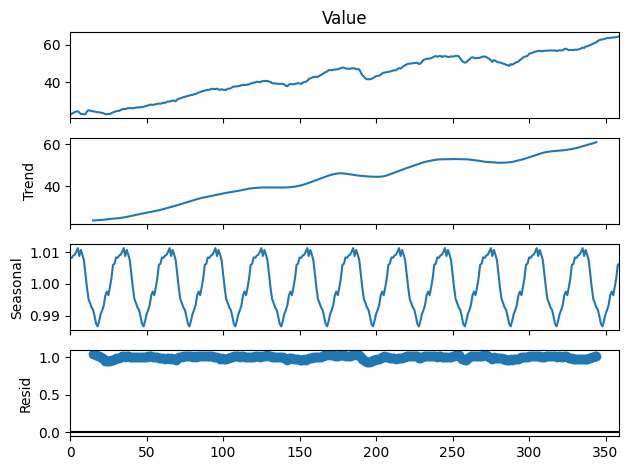

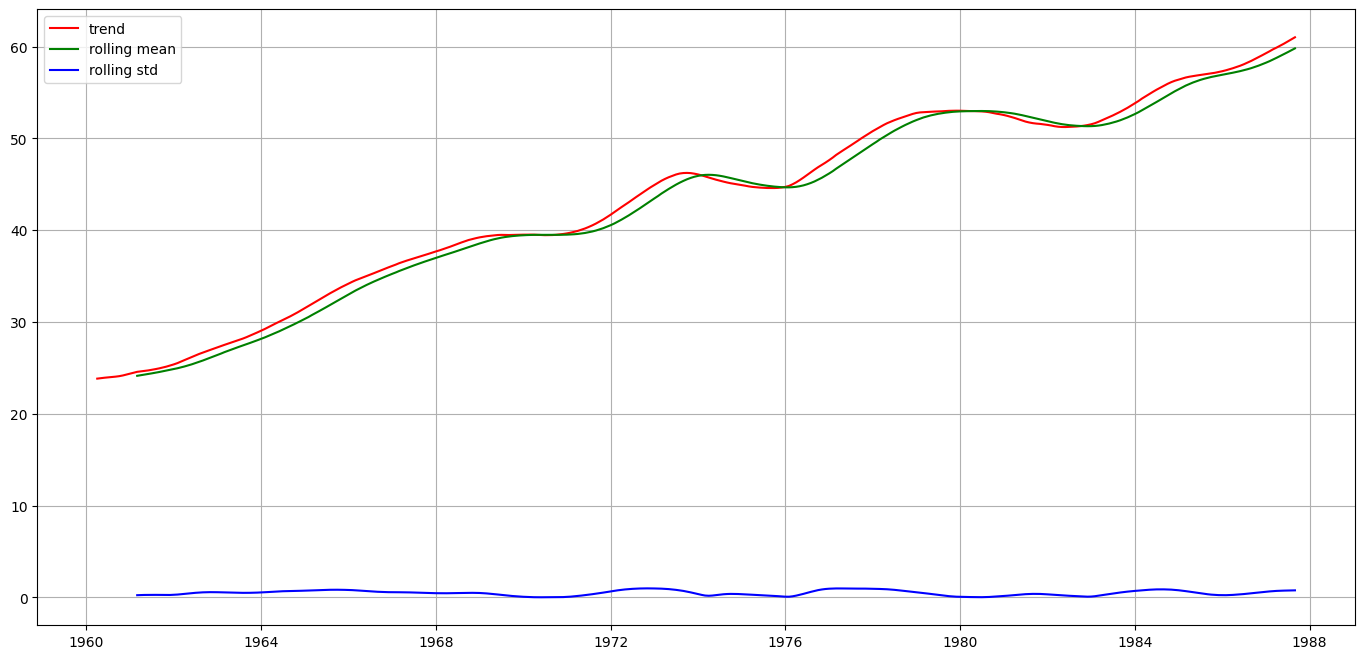

Ряд не стационарный


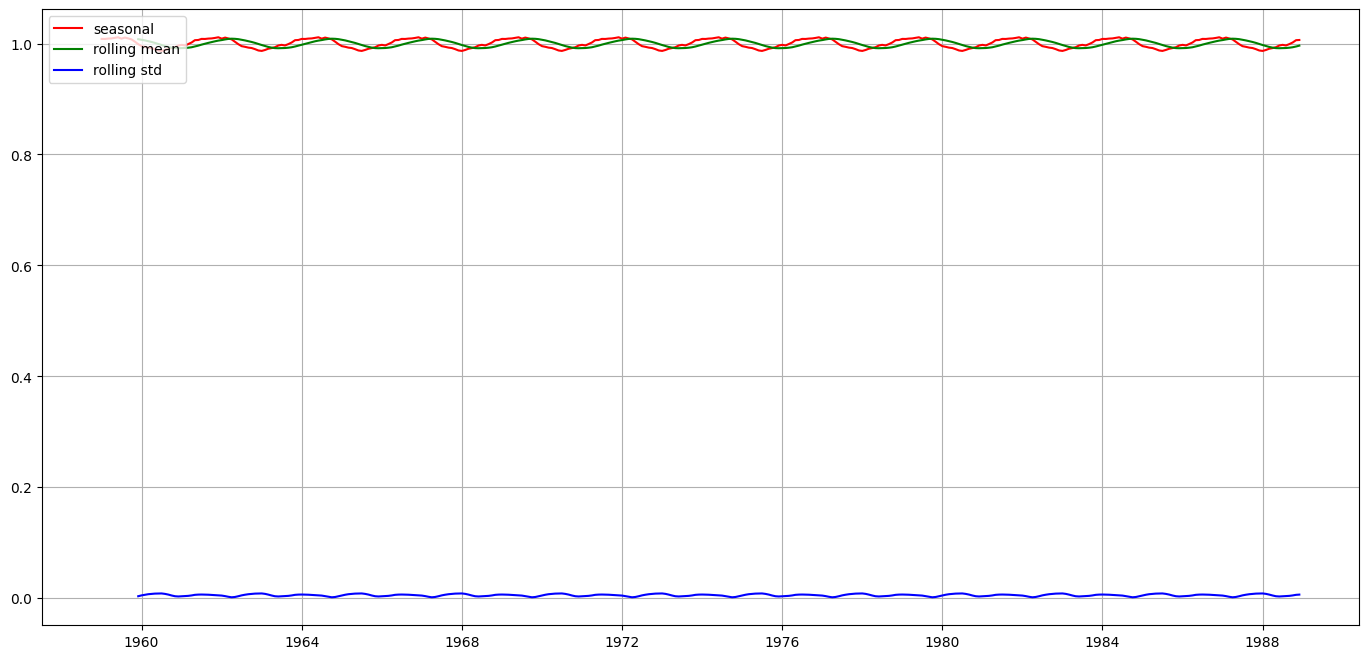

Ряд не стационарный


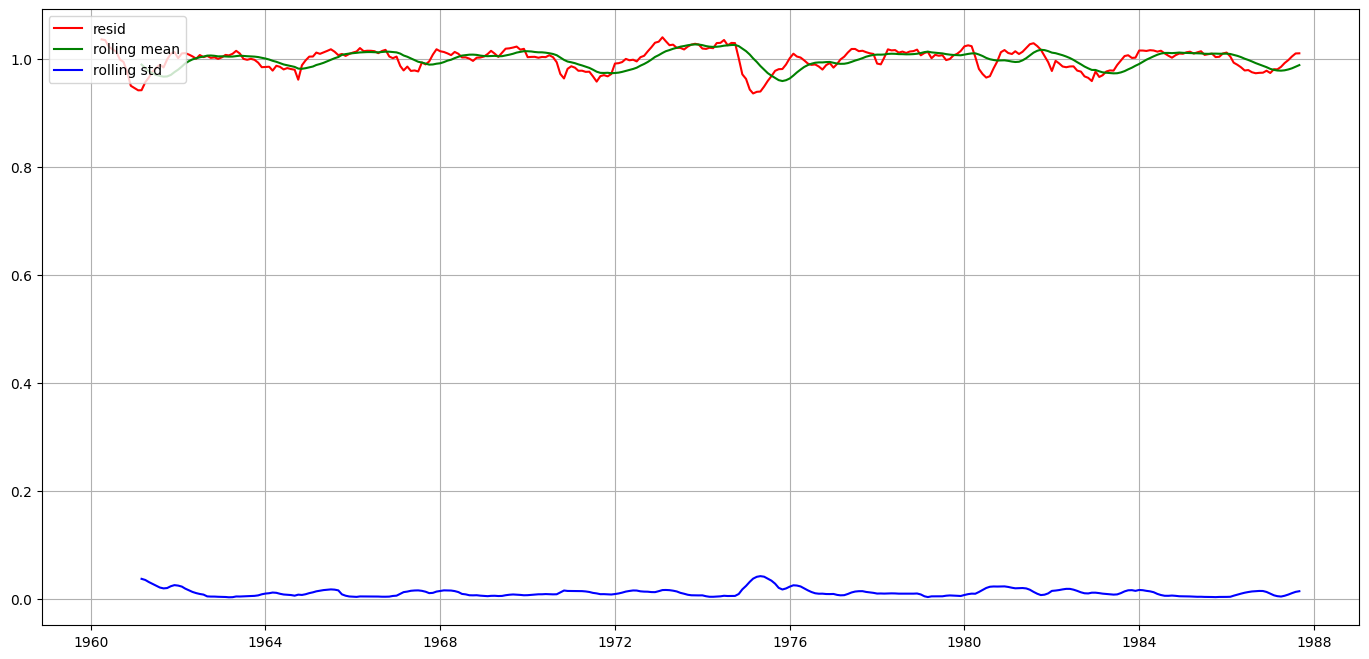

Ряд не стационарный


In [12]:

res = seasonal_decompose(data.Value, model='multiplicative',period=30)
res.plot()
plt.show()

test(res.trend, "trend")
test(res.seasonal, "seasonal")
test(res.resid, "resid")


## На самом деле, исходя из графиков для RESID и SEASONAL и в первом, и во втором случаях, ряды похожи на стационарные
## (возможно, ошибка исходит от плавающей арифметики)

## Проверим, является ли временной ряд интегрированным порядка k.
## Если искомый ряд не стационарный, то проверим разности k-ых порядков ряда c помощью pd.diff(periods=1).
## dropna() нужен для выбрасывания первого элемента, который всегда будет NaN

In [13]:
i = 1
DFA = adfuller(series)
if DFA[0] > DFA[4]['5%']:
    sd = series.diff(periods=1).dropna()
else:
    i = 0
k = 0
while i:
    DFA = adfuller(sd)
    if DFA[0] <= DFA[4]['5%']:
        i = 0
    sd = sd.diff(periods=1).dropna()
    k = k + 1

if k == 0:
    print("Ряд не является интегрированным")
else:
    print("Ряд является интегрированным порядка ",k )

Ряд является интегрированным порядка  1


In [14]:
sd = series.diff(periods=1).dropna() #так как мы вычли два раза

# функции автокорреляции и функции частичной автокорреляции

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


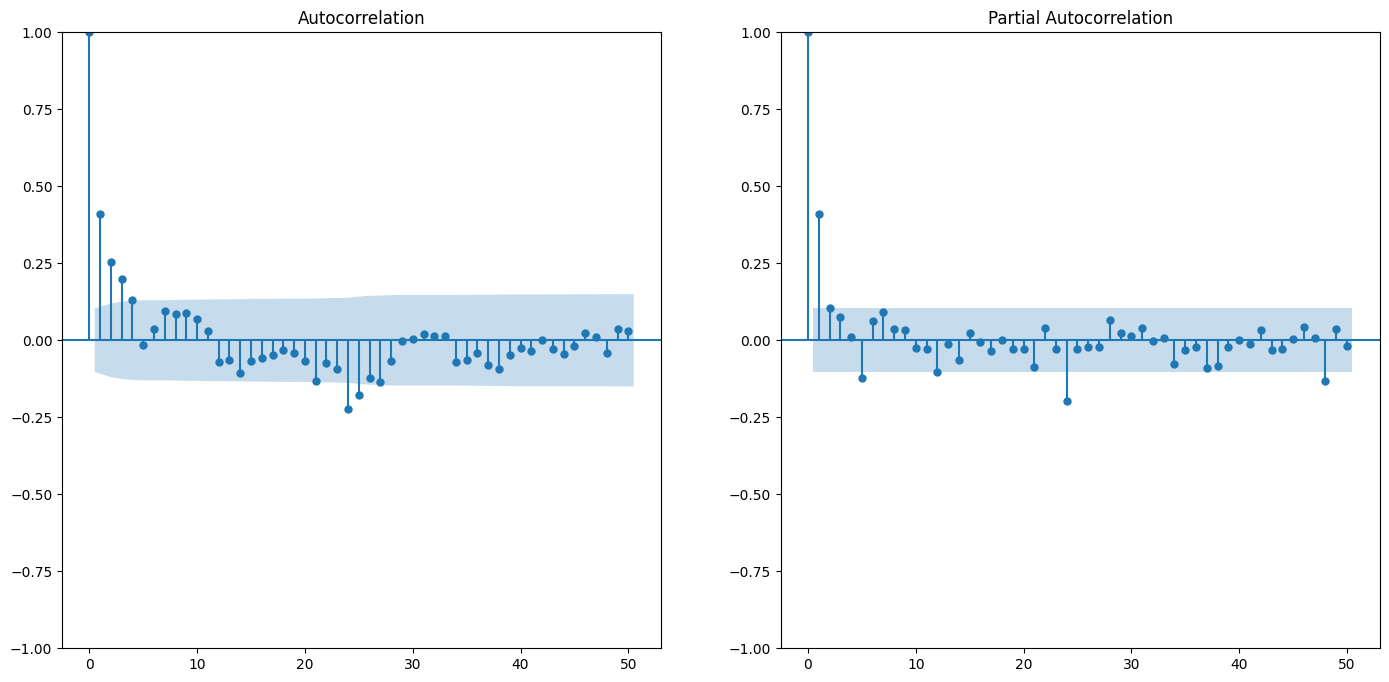

In [16]:

fig, ax = plt.subplots(1,2,figsize=(17,8))
plot_acf(sd.squeeze(), lags=50, ax=ax[0])
plot_pacf(sd.squeeze(), lags=50, ax=ax[1])
plt.show()

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score


In [18]:
test = pd.read_excel("Ответы.xlsx")
test_series = test.Value
series = data.Value

In [19]:

arima = ARIMA(series, order=(2, 1, 1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -124.427
Date:                Tue, 28 Nov 2023   AIC                            256.855
Time:                        10:00:23   BIC                            272.388
Sample:                             0   HQIC                           263.032
                                - 360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0592      0.186      5.688      0.000       0.694       1.424
ar.L2         -0.1766      0.107     -1.646      0.100      -0.387       0.034
ma.L1         -0.6752      0.173     -3.906      0.0

In [20]:
result = arima.predict(start=data.shape[0],end=data.shape[0] + test.shape[0] - 1, typ='levels')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [21]:
print("R2: ", r2_score(test_series,result ), " AIC:", arima.aic)


R2:  0.044785777103614866  AIC: 256.85458483863914


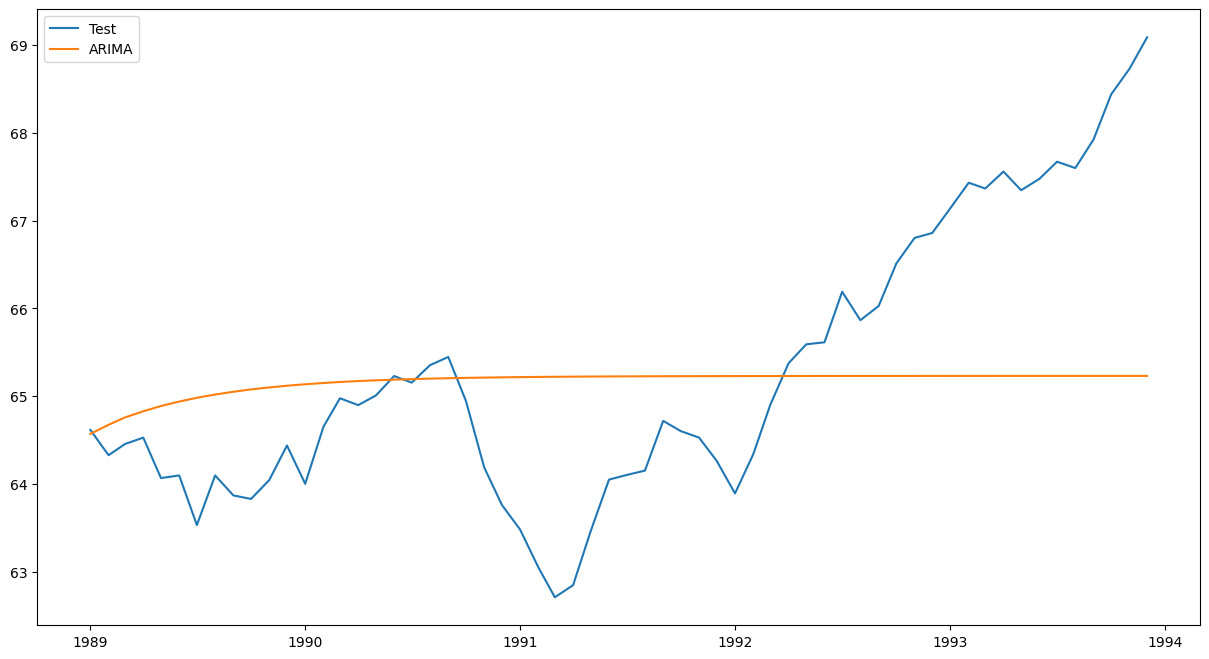

In [22]:
plt.figure(figsize=(15, 8))

plt.plot(test['Date'],test.Value, label='Test')
plt.plot(test['Date'],result, label='ARIMA')
plt.legend(loc='best')
plt.show()

In [23]:

arima2 = ARIMA(series.squeeze(), order=(2, 1, 2)).fit()
print(arima2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -124.478
Date:                Tue, 28 Nov 2023   AIC                            258.957
Time:                        10:00:25   BIC                            278.373
Sample:                             0   HQIC                           266.678
                                - 360                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7044      1.108      0.636      0.525      -1.466       2.875
ar.L2          0.0731      0.825      0.089      0.929      -1.545       1.691
ma.L1         -0.3219      1.102     -0.292      0.7

In [24]:

result2 = arima2.predict(start=data.shape[0],end=data.shape[0] + test.shape[0] - 1, typ='levels')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [25]:
print("R2: ", r2_score(test_series,result2), " AIC:", arima2.aic)


R2:  0.007271611996402805  AIC: 258.9566856298078


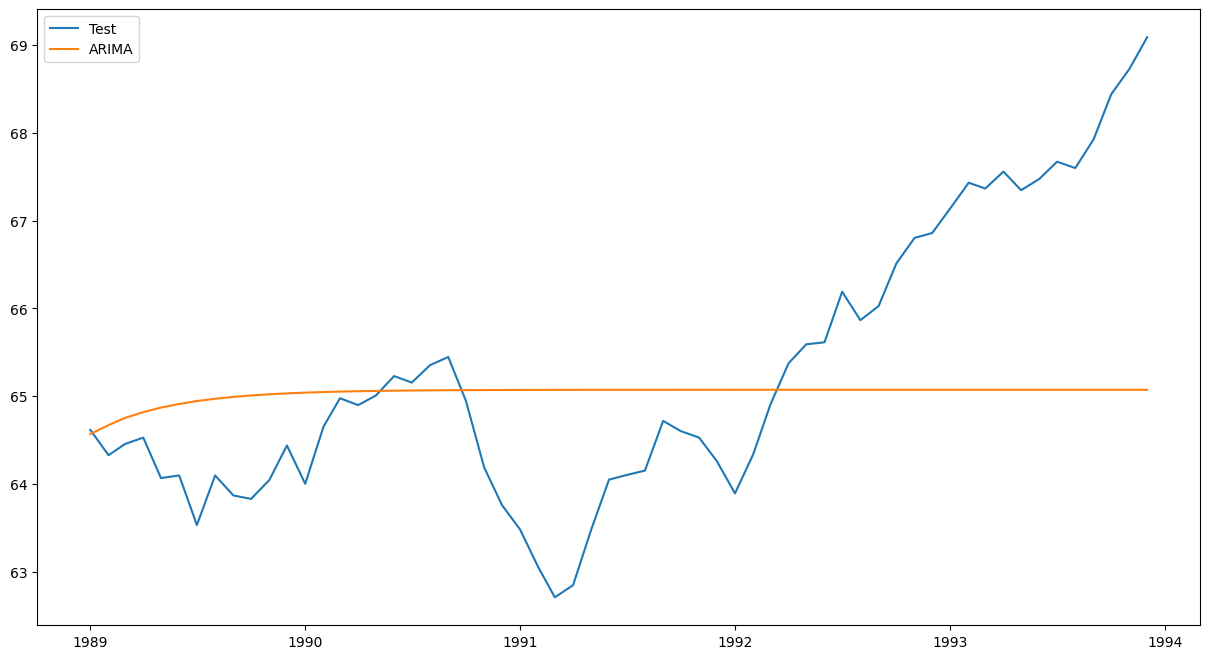

In [27]:
plt.figure(figsize=(15, 8))

plt.plot(test['Date'],test.Value, label='Test')
plt.plot(test['Date'],result2, label='ARIMA')
plt.legend(loc='best')
plt.show()#%%


# Выводы

### Оригинальный ряд и трендовая составляющая для обоих моделей не стационарны.
### Тест Дики-Фуллера подтверждает данный вывод.

### Сезонная составляющая и остаток (для одной из моделей) стационарны
### Лучший результат, который дал R2 score - это 0.044.
### Если результаты больше или меньше 1.0 то, это говорит об очень большой неточности предсказания модели.
### Поскольку у наших моделей значения -289 и -1.9, что говорит о том, что они не точные.
### Считается, что наилучшей будет модель с наименьшим значением критерия AIC, и в нашем случае это модель ARIMA с значением 248.

